## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.

## Solution

### Data preparation

In [150]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (auc, 
                             roc_curve, 
                             roc_auc_score, 
                             recall_score, 
                             precision_score)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [151]:
data = pd.read_csv('data.csv')

COLUMNS = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

data = data[COLUMNS]

In [152]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

data.fillna(0, inplace=True)

data['above_average'] = (data.msrp > data.msrp.mean())*1

data.drop('msrp', axis=1, inplace=True)

In [153]:
data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

y_train = data_train.above_average.values
y_val = data_val.above_average.values
y_test = data_test.above_average.values

del data_train['above_average']
del data_val['above_average']
del data_test['above_average']

### Question 1

In [154]:
NUMERICAL = [
    'year',
    'engine_hp',
    'engine_cylinders',
    'highway_mpg',
    'city_mpg'
]
CATEGORICAL = ['make', 'model', 'transmission_type', 'vehicle_style']

for c in NUMERICAL:
    auc_score = roc_auc_score(y_train, data_train[c])
    if auc_score<0.5:
        auc_score = roc_auc_score(y_train, -data_train[c])
    print(c, round(auc_score, 3))

year 0.688
engine_hp 0.917
engine_cylinders 0.766
highway_mpg 0.633
city_mpg 0.673


### Question 2

In [157]:
dv = DictVectorizer()
train_dicts = data_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = data_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred)
round(auc_score, 3)

0.912

### Question 3

In [130]:
def train(train_dataset, y_train, model):
    dv = DictVectorizer()
    train_dicts = train_dataset[CATEGORICAL+NUMERICAL].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[CATEGORICAL+NUMERICAL].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


CPU times: user 751 ms, sys: 0 ns, total: 751 ms
Wall time: 750 ms


/home/erick/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


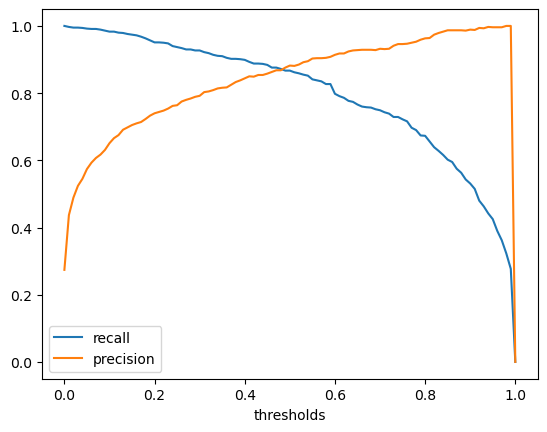

In [131]:
%%time

values = []
thresholds = np.arange(0, 1.01, 0.01)

dv, model = train(data_train, y_train, model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
y_pred = predict(data_val, dv, model)

for t in thresholds:
    y_pred_t = (y_pred>=t)*1
    precision = precision_score(y_val, y_pred_t)
    
    recall = recall_score(y_val, y_pred_t)
    values.append((t, round(precision,3), round(recall,3)))

df_precision_recall = pd.DataFrame(values, columns=['threshold', 'precision', 'recall'])

plt.plot(df_precision_recall.threshold, df_precision_recall.recall, label='recall')
plt.plot(df_precision_recall.threshold, df_precision_recall.precision, label='precision')
plt.xlabel('thresholds')
plt.legend()

### Question 4

In [132]:
df_precision_recall['f1'] = 2*(df_precision_recall.precision*df_precision_recall.recall)/(df_precision_recall.precision+df_precision_recall.recall)

In [133]:
df_precision_recall[df_precision_recall.f1==df_precision_recall.f1.max()]

,threshold,precision,recall,f1
50,0.5,0.882,0.867,0.874436


### Question 5

In [134]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores= []

for train_idx, val_idx in kfold.split(data_full_train):
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
    y_train = data_train.above_average
    y_val = data_val.above_average
    dv, model = train(data_train, y_train, model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    y_pred = predict(data_val, dv, model)
    auc_score = roc_auc_score(y_val, y_pred)
    scores.append(round(auc_score, 3))

In [135]:
np.array(scores).std()

0.003033150177620623

### Question 6

In [149]:
for C in [0.01, 0.1, 0.5, 10]:

    scores= []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(data_full_train):
        
        df_train = data_full_train.iloc[train_idx]
        df_val = data_full_train.iloc[val_idx]
       
        y_train = df_train.above_average
        y_val = df_val.above_average
       
        dv, model = train(df_train, y_train, model=LogisticRegression(solver='liblinear', C=C, max_iter=1000))
        y_pred = predict(df_val, dv, model)
       
        roc_auc = roc_auc_score(y_val, y_pred)
        scores.append(roc_auc)
    
    scores = np.array(scores)
    print('C:', f'{C:>4}', '-- mean:', round(scores.mean(), 3), '-- std:', round(scores.std(), 3))

C: 0.01 -- mean: 0.952 -- std: 0.002
C:  0.1 -- mean: 0.972 -- std: 0.002
C:  0.5 -- mean: 0.979 -- std: 0.001
C:   10 -- mean: 0.981 -- std: 0.003
